In [1]:
import numpy as np
import matplotlib.pyplot as plt
F = np.load('TibetanMNIST.npz')
columns = F.files
images = F['image']
images = images > (255//2)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
d_model = 10

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__();
        self.Dense1 = nn.Linear(28*28, 600)
        self.Dense2 = nn.Linear(600, 300)
        self.Dense3 = nn.Linear(300, 150)
        self.Dense4 = nn.Linear(150, 75)
        self.Dense5 = nn.Linear(75, d_model)
    def forward(self, x):
        X = nn.Tanh()(self.Dense1(x))
        X = nn.Tanh()(self.Dense2(X))
        X = nn.Tanh()(self.Dense3(X))
        X = nn.Tanh()(self.Dense4(X))
        X = self.Dense5(X)
        return X

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.Dense1 = nn.Linear(d_model, 75)
        self.Dense2 = nn.Linear(75, 150)
        self.Dense3 = nn.Linear(150, 300)
        self.Dense4 = nn.Linear(300, 600)
        self.Dense5 = nn.Linear(600, 28*28)
    def forward(self ,x):
        X = nn.Tanh()(self.Dense1(x))
        X = nn.Tanh()(self.Dense2(X))
        X = nn.Tanh()(self.Dense3(X))
        X = nn.Tanh()(self.Dense4(X))
        X = nn.Sigmoid()(self.Dense5(X))
        return X   

# 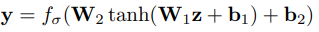

In [1]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()
        self.Dense1 = nn.Linear(784, 512)
        #self.Dense2 = nn.Linear(512, 258)
        self.Dense3 = nn.Linear(512, d_model)
        self.Dense4 = nn.Linear(512, d_model)
        self.Distribution = torch.distributions.Normal(torch.tensor(0).to(device=torch.device("cuda")),
                                                       torch.tensor(1).to(device=torch.device("cuda")))

    def forward(self, x):
        X = torch.flatten(x, start_dim=1)
        X = nn.ReLU()(self.Dense1(X)) 
        #X = nn.ReLU()(self.Dense2(X))
        self.mu =  self.Dense3(X) # N, 2
        self.sigma = torch.exp(self.Dense4(X)/2) # N, 2
        z = self.mu + self.sigma*self.Distribution.sample(self.mu.shape) # (N, 2)(N, 2)
        return z

class VariationalDecoder(nn.Module):
    def __init__(self):
        super(VariationalDecoder, self).__init__()
        self.Dense1 = nn.Linear(d_model, 512)
        #self.Dense2 = nn.Linear(258, 512)
        self.Dense3 = nn.Linear(512, 784)
        
    def forward(self, x): # (N, 2)
        X = nn.ReLU()(self.Dense1(x)) # (N, 2) -> (N, 512)
        #X = nn.ReLU()(self.Dense2(X)) # (N, 2) -> (N, 512)
        X = nn.Sigmoid()(self.Dense3(X)) # (N, 512) -> (N, 784)
        return X

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = Decoder()
        self.Decoder = VariationalDecoder()

    def forward(self, x):
        z = self.encoder(x)
        #z = self.decoder(z)
        Result = self.Decoder(z)
        return Result
    


NameError: name 'nn' is not defined

In [6]:
X = torch.from_numpy(images.reshape(images.shape[0], -1)).to(torch.float32)

In [7]:
model = VariationalAutoencoder()
LOSS = nn.BCELoss(reduction = 'sum')
OPT = torch.optim.Adam(model.parameters(), lr = 0.001)

In [8]:
Losses = list()
for epoch in range(150):
    loss_val = 0
    for batch in range(0, X.shape[0], 128):
        if batch + 128 > X.shape[0]:
            x = X[batch:]
        else:
            x = X[batch:batch + 128]
        OPT.zero_grad()
        output = model(x)
        BCE = LOSS(output, x)
        sigma = model.encoder.sigma
        mu = model.encoder.mu
        KL = - 0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma))
        loss = BCE + KL
        loss.backward()
        OPT.step()
        
    output = model(X)
    loss = LOSS(output, X)
    loss_val = float(loss)
    Losses.append(loss_val)
    print("Epoch: {0}; Loss: {1}".format(epoch + 1, loss_val))

Epoch: 1; Loss: 2255826.0
Epoch: 2; Loss: 1858527.75
Epoch: 3; Loss: 1728596.375
Epoch: 4; Loss: 1644913.25
Epoch: 5; Loss: 1580368.875
Epoch: 6; Loss: 1554967.125
Epoch: 7; Loss: 1492856.25
Epoch: 8; Loss: 1459177.125
Epoch: 9; Loss: 1428925.25
Epoch: 10; Loss: 1406916.75
Epoch: 11; Loss: 1389707.25
Epoch: 12; Loss: 1361298.25
Epoch: 13; Loss: 1343692.25
Epoch: 14; Loss: 1336555.75
Epoch: 15; Loss: 1326153.0
Epoch: 16; Loss: 1315325.0
Epoch: 17; Loss: 1299862.375
Epoch: 18; Loss: 1297039.75
Epoch: 19; Loss: 1283443.75
Epoch: 20; Loss: 1276660.25
Epoch: 21; Loss: 1253296.75
Epoch: 22; Loss: 1241372.5
Epoch: 23; Loss: 1237177.25
Epoch: 24; Loss: 1260765.75
Epoch: 25; Loss: 1238580.375
Epoch: 26; Loss: 1229121.5
Epoch: 27; Loss: 1229593.375
Epoch: 28; Loss: 1229196.5
Epoch: 29; Loss: 1231720.0
Epoch: 30; Loss: 1217880.75
Epoch: 31; Loss: 1222605.5
Epoch: 32; Loss: 1200686.25
Epoch: 33; Loss: 1189274.0
Epoch: 34; Loss: 1184170.5
Epoch: 35; Loss: 1181055.875
Epoch: 36; Loss: 1183025.5
Epoc

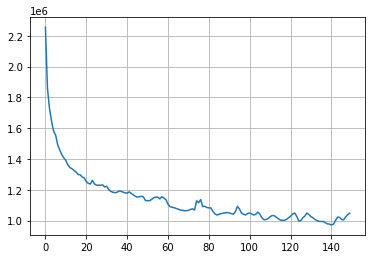

In [9]:
plt.plot(Losses)
plt.grid()
plt.show()

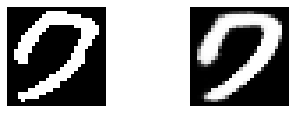

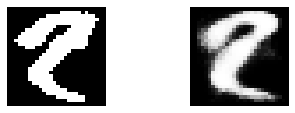

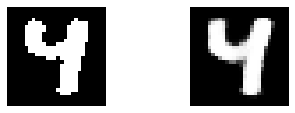

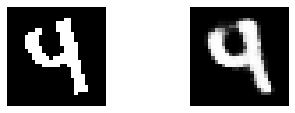

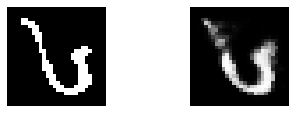

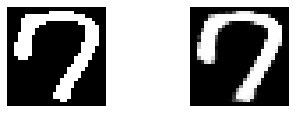

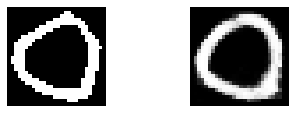

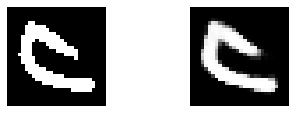

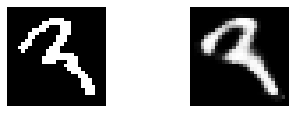

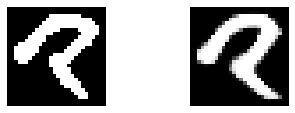

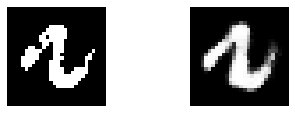

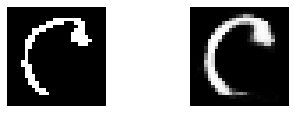

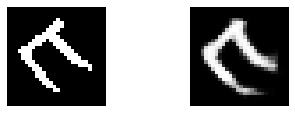

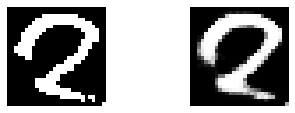

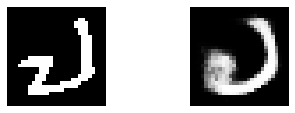

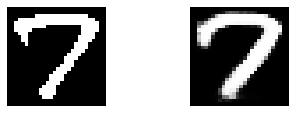

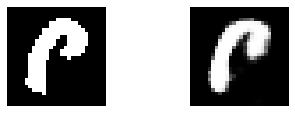

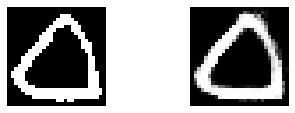

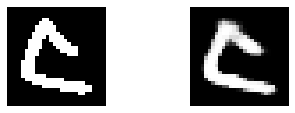

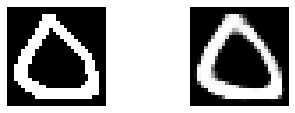

In [10]:
for i in range(20):
    Predict = (model(X[i].reshape(1, -1))[0]).reshape(28, 28).detach().numpy()
    plt.subplot(2, 2, 1)
    plt.imshow(images[i], cmap='Greys_r')
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(Predict, cmap='Greys_r')
    plt.axis('off')
    plt.show()

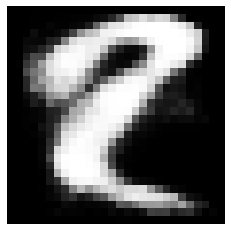

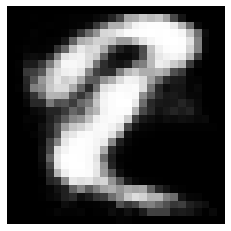

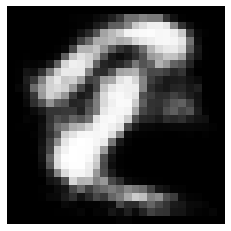

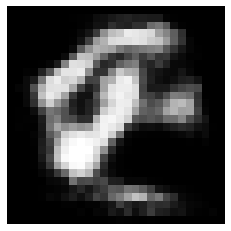

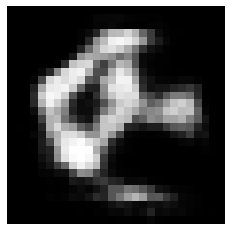

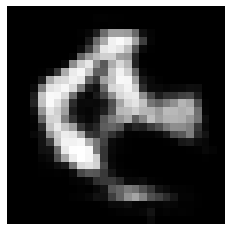

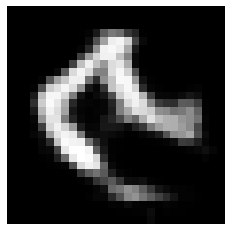

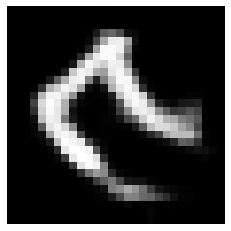

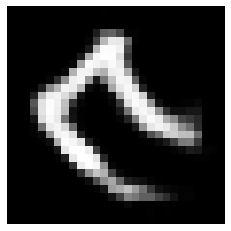

In [77]:
z1 = model.encoder(X[1:2])[0]
z2 = model.encoder(X[12:13])[0]
div = 8
epsilon = (z2 - z1)/8
for i in range(div + 1):   
    plt.imshow(model.Decoder.forward(z1 + i*epsilon).reshape(28, 28).detach(), cmap = 'gray')
    plt.axis('off')
    plt.show()

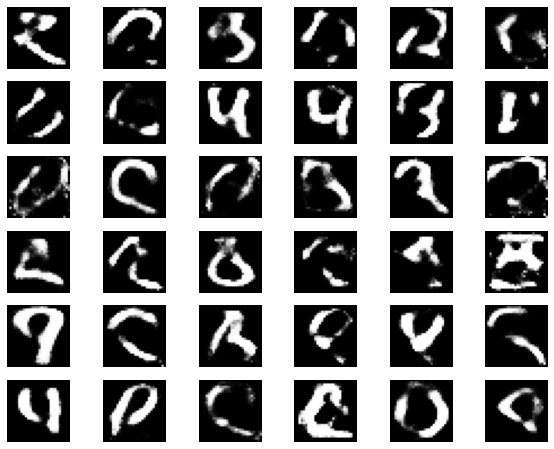

In [78]:
def _torch_unif(size, low = -1, high = 1):
    N = torch.distributions.Normal(0, 1)
    result = N.sample(size)
    return result
k = 1
plt.figure(figsize = (10, 8))
for i in range(6):
    for j in range(6):
        z = _torch_unif((d_model, ))
        plt.subplot(6, 6, k)
        plt.imshow(model.Decoder.forward(z).reshape((28, 28)).detach(), cmap='Greys_r')
        plt.axis('off')
        k += 1

In [99]:
print('各個latent code的mean和variance：')
model.encoder.mu, model.encoder.sigma

各個latent code的mean和variance：


(tensor([[-0.7994, -1.4796, -0.0281,  0.3513,  0.1489, -0.8575,  1.0886, -0.2279,
          -0.4735, -0.5059]], grad_fn=<AddmmBackward0>),
 tensor([[0.0005, 0.0004, 0.0003, 0.0008, 0.0005, 0.0006, 0.0005, 0.0005, 0.0004,
          0.0004]], grad_fn=<ExpBackward0>))

In [80]:
model2 = VariationalAutoencoder()
LOSS = nn.BCELoss(reduction = 'sum')
OPT = torch.optim.Adam(model2.parameters(), lr = 0.001)
Losses = list()
Lambda = 100
for epoch in range(150):
    loss_val = 0
    for batch in range(0, X.shape[0], 128):
        if batch + 128 > X.shape[0]:
            x = X[batch:]
        else:
            x = X[batch:batch + 128]
        OPT.zero_grad()
        output = model2(x)
        BCE = LOSS(output, x)
        sigma = model2.encoder.sigma
        mu = model2.encoder.mu
        KL = Lambda*(- 0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma)))
        loss = BCE + KL
        loss.backward()
        OPT.step()
        
    output = model2(X)
    loss = LOSS(output, X)
    loss_val = float(loss)
    Losses.append(loss_val)
    print("Epoch: {0}; Loss: {1}".format(epoch + 1, loss_val))

Epoch: 1; Loss: 3644965.75
Epoch: 2; Loss: 2845858.5
Epoch: 3; Loss: 2446248.5
Epoch: 4; Loss: 2207741.25
Epoch: 5; Loss: 2106312.0
Epoch: 6; Loss: 2058713.875
Epoch: 7; Loss: 1977157.5
Epoch: 8; Loss: 1933852.375
Epoch: 9; Loss: 1923132.25
Epoch: 10; Loss: 1917117.75
Epoch: 11; Loss: 1886248.875
Epoch: 12; Loss: 1840095.0
Epoch: 13; Loss: 1797278.625
Epoch: 14; Loss: 1864159.25
Epoch: 15; Loss: 1757261.375
Epoch: 16; Loss: 1718138.5
Epoch: 17; Loss: 1718116.0
Epoch: 18; Loss: 1726281.75
Epoch: 19; Loss: 1683385.375
Epoch: 20; Loss: 1647012.75
Epoch: 21; Loss: 1628383.75
Epoch: 22; Loss: 1624649.875
Epoch: 23; Loss: 1618232.25
Epoch: 24; Loss: 1600301.875
Epoch: 25; Loss: 1597898.5
Epoch: 26; Loss: 1575952.75
Epoch: 27; Loss: 1572395.5
Epoch: 28; Loss: 1542961.375
Epoch: 29; Loss: 1547103.5
Epoch: 30; Loss: 1546118.875
Epoch: 31; Loss: 1523593.25
Epoch: 32; Loss: 1513083.625
Epoch: 33; Loss: 1534294.0
Epoch: 34; Loss: 1519912.5
Epoch: 35; Loss: 1468852.25
Epoch: 36; Loss: 1485165.0
Epo

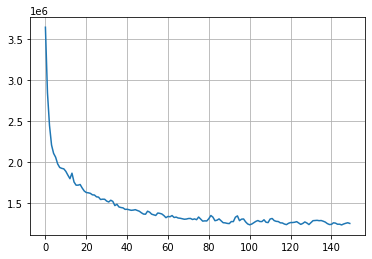

In [81]:
plt.plot(Losses)
plt.grid()
plt.show()

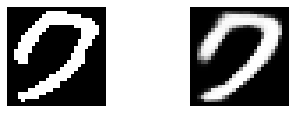

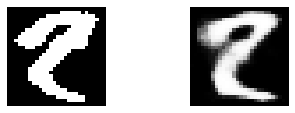

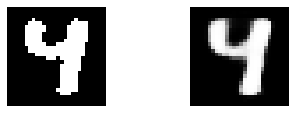

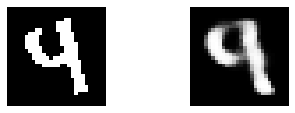

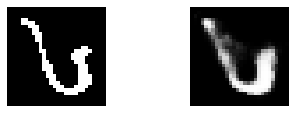

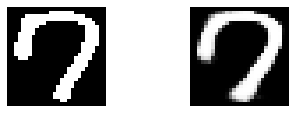

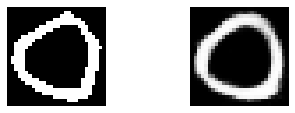

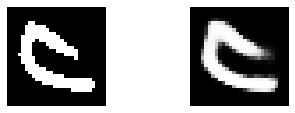

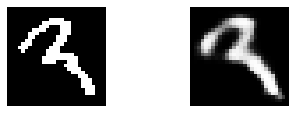

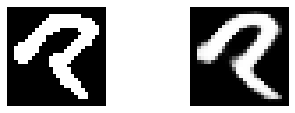

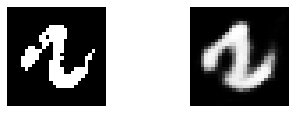

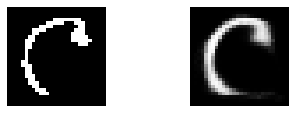

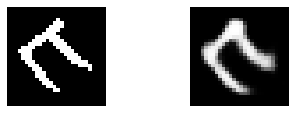

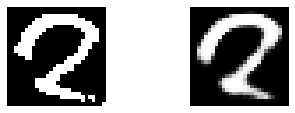

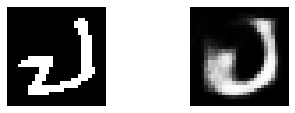

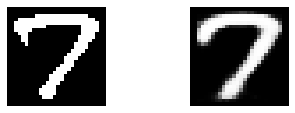

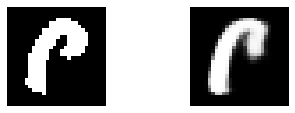

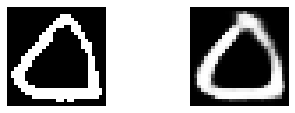

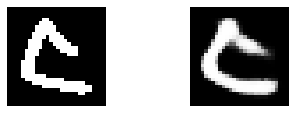

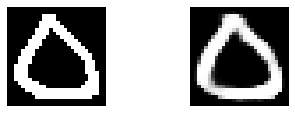

In [85]:
for i in range(20):
    Predict = (model2(X[i].reshape(1, -1))[0]).reshape(28, 28).detach().numpy()
    plt.subplot(2, 2, 1)
    plt.imshow(images[i], cmap='Greys_r')
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(Predict, cmap='Greys_r')
    plt.axis('off')
    plt.show()

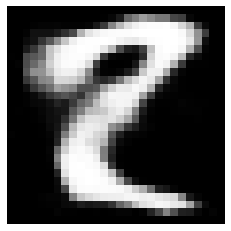

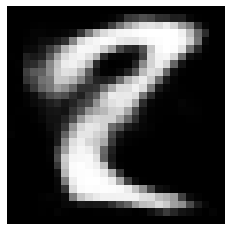

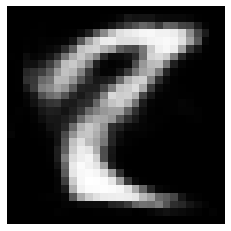

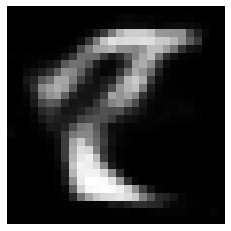

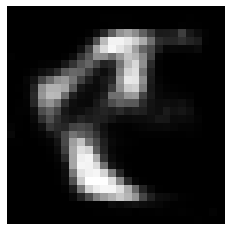

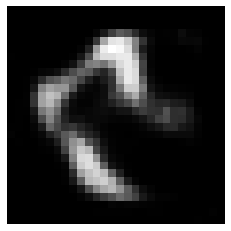

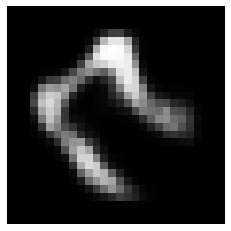

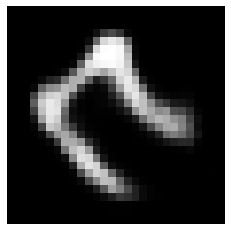

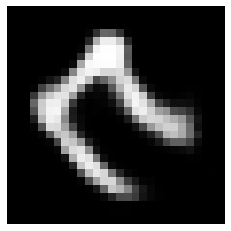

In [86]:
z1 = model2.encoder(X[1:2])[0]
z2 = model2.encoder(X[12:13])[0]
div = 8
epsilon = (z2 - z1)/8
for i in range(div + 1):   
    plt.imshow(model2.Decoder.forward(z1 + i*epsilon).reshape(28, 28).detach(), cmap = 'gray')
    plt.axis('off')
    plt.show()

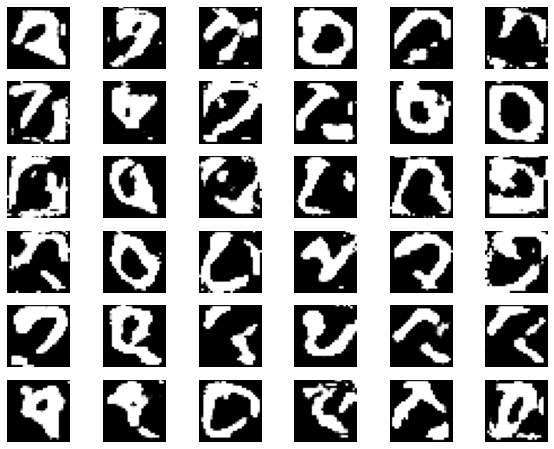

In [87]:
def _torch_unif(size, low = -1, high = 1):
    N = torch.distributions.Normal(0, 1)
    result = N.sample(size)
    return result
k = 1
plt.figure(figsize = (10, 8))
for i in range(6):
    for j in range(6):
        z = _torch_unif((d_model, ))
        plt.subplot(6, 6, k)
        plt.imshow(model2.Decoder.forward(z).reshape((28, 28)).detach(), cmap='Greys_r')
        plt.axis('off')
        k += 1

In [98]:
print('各個latent code的mean和variance：')
model2.encoder.mu, model2.encoder.sigma

各個latent code的mean和variance：


(tensor([[ 0.0608, -0.0930, -0.0103,  0.1285, -0.0729,  0.0065, -0.0637,  0.2195,
           0.1718,  0.0741]], grad_fn=<AddmmBackward0>),
 tensor([[8.0246e-05, 1.1410e-04, 9.5262e-05, 1.0478e-04, 1.1398e-04, 7.5520e-05,
          8.1152e-05, 9.6265e-05, 8.1753e-05, 7.2281e-05]],
        grad_fn=<ExpBackward0>))

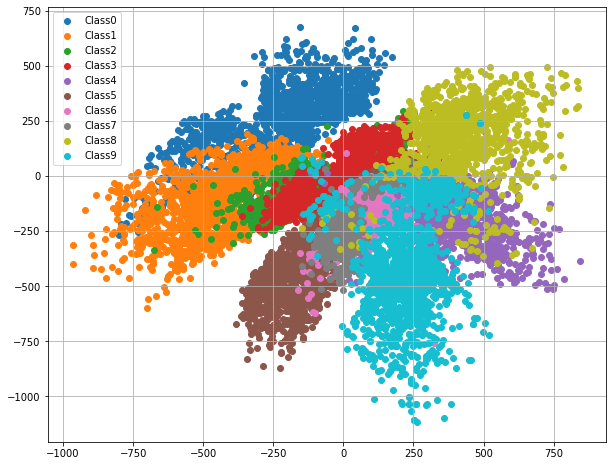

In [12]:
f = np.load('TibetanMNIST.npz')
LIST = list(set(f[columns[1]]))
plt.figure(figsize = (10, 8))
for Class in LIST:
    I = np.where(f[columns[1]] == Class)[0]
    output = model.encoder(torch.tensor(f['image'][I]).reshape(-1, 28*28).to(torch.float32))
    plt.scatter(output[:,0].detach().numpy(), output[:,1].detach().numpy(), label = 'Class' + str(int(Class)))
plt.legend()
plt.grid()
plt.show()